# CFPB Complaint Data: EDA and Preprocessing

This notebook performs exploratory data analysis (EDA) and preprocessing on the CFPB complaint dataset to prepare it for a Retrieval-Augmented Generation (RAG) chatbot.

In [9]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

## 1. Load the CFPB Complaint Dataset
We load the raw complaints data from the provided CSV file.

In [10]:
# Load the dataset
data_path = '../data/raw/complaints.csv'
df = pd.read_csv(data_path)
df.head()

C:\Users\DAFtech\AppData\Local\Temp\ipykernel_33712\2674524464.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## 2. Initial EDA
Let's examine the structure, columns, and a few sample rows.

In [11]:
# Dataset info
df.info()
# Show column names
print(df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

## 3. Distribution of Complaints by Product
Visualize the number of complaints for each product.

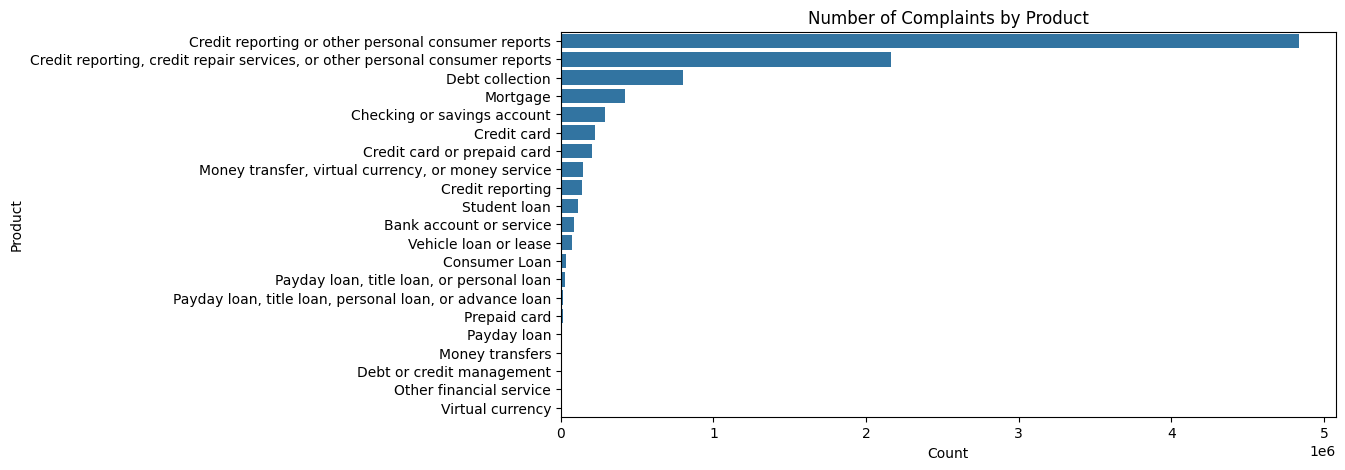

In [12]:
# Distribution by Product
plt.figure(figsize=(10,5))
sns.countplot(y='Product', data=df, order=df['Product'].value_counts().index)
plt.title('Number of Complaints by Product')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show()

## 4. Analyze Narrative Lengths
Calculate and visualize the word count of the 'Consumer complaint narrative'.

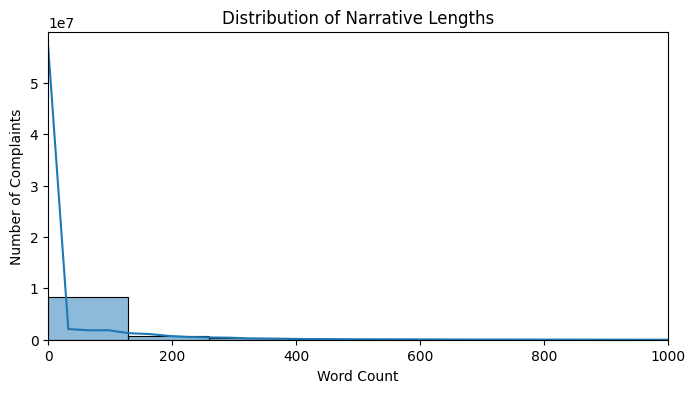

count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64

In [13]:
# Add word count column
df['narrative_length'] = df['Consumer complaint narrative'].fillna('').apply(lambda x: len(str(x).split()))
# Plot distribution
plt.figure(figsize=(8,4))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Narrative Lengths')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.xlim(0, 1000)  # Limit x-axis to 0-1000 words
plt.show()
# Show stats
df['narrative_length'].describe()

## 5. Complaints With and Without Narratives
Count how many complaints have a narrative and how many do not.

In [14]:
# Complaints with/without narrative
has_narrative = df['Consumer complaint narrative'].notnull() & (df['Consumer complaint narrative'].str.strip() != '')
print('With narrative:', has_narrative.sum())
print('Without narrative:', (~has_narrative).sum())

With narrative: 2980756
Without narrative: 6629041


## 6. Filter Dataset for Project Requirements
Keep only the five specified products and remove empty narratives.

In [15]:
# Filter for specified products
products = ['Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', 'Money transfers']
filtered = df[df['Product'].isin(products)]
# Remove empty narratives
filtered = filtered[filtered['Consumer complaint narrative'].notnull() & (filtered['Consumer complaint narrative'].str.strip() != '')]
filtered.shape

(82164, 19)

## 7. Clean Text Narratives
Lowercase, remove special characters, and boilerplate text.

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'i am writing to file a complaint.*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
filtered['cleaned_narrative'] = filtered['Consumer complaint narrative'].apply(clean_text)
filtered[['Product', 'cleaned_narrative']].head()

,Product,cleaned_narrative
12237,Credit card,a xxxx xxxx card was opened under my name by a...
13280,Credit card,dear cfpb i have a secured credit card with ci...
13506,Credit card,i have a citi rewards cards the credit balance...
13955,Credit card,bi am writing to dispute the following charges...
14249,Credit card,although the account had been deemed closed i ...


## 8. Save Cleaned and Filtered Dataset
Save the processed data to `data/filtered_complaints.csv`.

In [17]:
output_path = '../data/filtered_complaints.csv'
filtered.to_csv(output_path, index=False)
print(f'Saved cleaned data to {output_path}')

Saved cleaned data to ../data/filtered_complaints.csv


# Summary of EDA Findings

- The dataset contains complaints across multiple financial products, with the five specified products filtered for this project.
- There is a wide range in the length of consumer complaint narratives, with some very short and some very long entries.
- A significant portion of complaints lack a narrative, which were removed for downstream tasks.
- Text cleaning was performed to standardize and prepare narratives for embedding in the RAG pipeline.